In [1]:
import pandas as pd
import numpy as np
import matplotlib
import torch
from glob import glob
import os
import json
from ecog_speech import datasets, feature_processing, experiments, utils
from ecog_speech.models import base
from tqdm.auto import tqdm

%matplotlib inline

### Load result JSON files into a list of objects

In [2]:
from ecog_speech import result_parsing

In [3]:
# Link a results dir in the project root
base_path = "../ecog_speech/results_per_patient_sn_2105/"
result_files = glob(os.path.join(base_path, '*.json'))

json_result_data = [json.load(open(f)) for f in tqdm(result_files)]

0it [00:00, ?it/s]

Parse into dataframe

In [27]:
results_df = pd.DataFrame(json_result_data).sort_values('f1', ascending=False)

results_df.columns

Index(['name', 'datetime', 'uid', 'batch_losses', 'best_model_epoch',
       'num_trainable_params', 'num_params', 'model_kws', 'clf_reports', 'f1',
       'accuracy', 'precision', 'recall', 'model_name', 'dataset',
       'train_sets', 'cv_sets', 'test_sets', 'random_labels', 'learning_rate',
       'dense_width', 'sn_n_bands', 'sn_kernel_size', 'sn_padding',
       'n_cnn_filters', 'dropout', 'dropout_2d', 'in_channel_dropout_rate',
       'batchnorm', 'roll_channels', 'shuffle_channels', 'cog_attn',
       'bw_reg_weight', 'track_sinc_params', 'power_q', 'n_epochs',
       'batch_size', 'device', 'save_model_path', 'tag', 'result_dir',
       'low_hz_frame', 'high_hz_frame', 'path'],
      dtype='object')

Config params are those parameters we want to split by if experiments were run with different values
- Use pandas to detect which config parameters were actually changed from the provided superset

In [28]:
import seaborn as sns

# Choose a metric
perf_col = 'f1'

performance_cols = ['accuracy', 'f1', 'precision']
config_params = ['model_name', 'dataset', 'dense_width',
                 'sn_n_bands', 'sn_kernel_size', 'sn_padding',
                 'bw_reg_weight', 'cog_attn', 'shuffle_channels',
                 'n_cnn_filters', 'dropout', 'dropout_2d', 'in_channel_dropout_rate',
                 'batchnorm', 'roll_channels', 'power_q', 'n_epochs']

results_df['bw_reg_weight'] = results_df['bw_reg_weight'].fillna(-1)
results_df['test_patient'] = results_df['test_sets'].str.split('-').apply(lambda l: '-'.join(l[:-1]))
results_df['test_fold'] = results_df['test_sets'].str.split('-').apply(lambda l: l[-1])

In [29]:
nun_config_params = results_df[config_params].nunique()

config_cols = nun_config_params[nun_config_params > 1].index.tolist()
fixed_config_cols = nun_config_params[nun_config_params == 1].index.tolist()
print(f"Fixed Params: {', '.join(fixed_config_cols)}")
print(f"Changing Params: {', '.join(config_cols)}")

Fixed Params: model_name, dataset, sn_kernel_size, sn_padding, bw_reg_weight, cog_attn, shuffle_channels, dropout, dropout_2d, batchnorm, roll_channels, power_q, n_epochs
Changing Params: sn_n_bands, n_cnn_filters, in_channel_dropout_rate


### What did we load? Patient and model type counts 
- Which patients are there results on, for which datasets

In [30]:
pd.crosstab(results_df.test_patient, results_df.model_name)

model_name,base-sn
test_patient,
MC-19,35
MC-21,48
MC-24,72
MC-25,48


### A unique experiment is a combination of the **_configuration parameters_**, a **_test_patient_**, and the **_test_fold_**
    - **configuraiton parameters**: All configuration parameters to consider in variable `config_params`, but the ones that vary in the experiments loaded are stored in `config_cols` and the remaining are in `fixed_config_cols`. We are generally interested in how performance and output changes between these various combinations of configurations.
    - **test_patient** and **test_fold**: Each patient has at least 2 trials available, so k-fold at the trial level will result in multiple fits per model config, but with varying train/test sets. We want to aggregate these folds (mean/std) to understand a model configurations performance on a patient.

In [31]:
results_df[performance_cols + config_params].describe(include='all')

,accuracy,f1,precision,model_name,dataset,dense_width,sn_n_bands,sn_kernel_size,sn_padding,bw_reg_weight,cog_attn,shuffle_channels,n_cnn_filters,dropout,dropout_2d,in_channel_dropout_rate,batchnorm,roll_channels,power_q,n_epochs
count,203.000000,203.000000,203.000000,203,203,0,203.000000,203.0,203.0,203.0,203,203,203.000000,203.0,203,203.000000,203,203,2.030000e+02,203.0
unique,NaN,NaN,NaN,1,1,0,NaN,NaN,NaN,NaN,1,1,NaN,NaN,1,NaN,1,1,NaN,NaN
top,NaN,NaN,NaN,base-sn,nww,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,False,NaN,True,False,NaN,NaN
freq,NaN,NaN,NaN,203,203,NaN,NaN,NaN,NaN,NaN,203,203,NaN,NaN,203,NaN,203,203,NaN,NaN
mean,0.820289,0.819220,0.821753,NaN,NaN,NaN,3.729064,31.0,15.0,0.0,NaN,NaN,37.201970,0.0,NaN,0.206897,NaN,NaN,7.000000e-01,15.0
std,0.174203,0.176846,0.176479,NaN,NaN,NaN,2.677462,0.0,0.0,0.0,NaN,NaN,19.965654,0.0,NaN,0.246865,NaN,NaN,6.677806e-16,0.0
min,0.412681,0.380228,0.408709,NaN,NaN,NaN,1.000000,31.0,15.0,0.0,NaN,NaN,16.000000,0.0,NaN,0.000000,NaN,NaN,7.000000e-01,15.0
25%,0.774239,0.758623,0.783314,NaN,NaN,NaN,1.500000,31.0,15.0,0.0,NaN,NaN,16.000000,0.0,NaN,0.000000,NaN,NaN,7.000000e-01,15.0
50%,0.887333,0.888766,0.877977,NaN,NaN,NaN,2.000000,31.0,15.0,0.0,NaN,NaN,32.000000,0.0,NaN,0.000000,NaN,NaN,7.000000e-01,15.0
75%,0.951225,0.950939,0.963240,NaN,NaN,NaN,4.000000,31.0,15.0,0.0,NaN,NaN,64.000000,0.0,NaN,0.500000,NaN,NaN,7.000000e-01,15.0


### Are there any repeated runs?
- If so, they will need to be aggregated

In [32]:
results_df.groupby(['test_patient', 'test_fold'] + config_cols).size().sort_values(ascending=False)

test_patient  test_fold  sn_n_bands  n_cnn_filters  in_channel_dropout_rate
MC-25         1          8           64             0.5                        1
MC-21         1          1           64             0.0                        1
                         4           32             0.0                        1
                                     16             0.5                        1
                                                    0.0                        1
                                                                              ..
MC-24         2          1           16             0.5                        1
                                                    0.0                        1
              1          8           64             0.5                        1
                                                    0.0                        1
MC-19         0          1           16             0.0                        1
Length: 203, dtype: int64

### What are the "fixed" configuration options? (i.e. not changing within these results and can be factored out)

In [33]:
results_df[fixed_config_cols].drop_duplicates()

,model_name,dataset,sn_kernel_size,sn_padding,bw_reg_weight,cog_attn,shuffle_channels,dropout,dropout_2d,batchnorm,roll_channels,power_q,n_epochs
60,base-sn,nww,31,15,0.0,False,False,0.0,False,True,False,0.7,15


## Performance for each configuration, for each patient

In [34]:
results_df.groupby(['test_patient'] + config_cols)[performance_cols].mean()

accuracy  \
test_patient sn_n_bands n_cnn_filters in_channel_dropout_rate             
MC-19        1          16            0.0                      0.941754   
                        32            0.0                      0.935580   
                        64            0.0                      0.940430   
             2          16            0.0                      0.936700   
                        32            0.0                      0.938763   
...                                                                 ...   
MC-25        8          16            0.5                      0.572572   
                        32            0.0                      0.505152   
                                      0.5                      0.563283   
                        64            0.0                      0.492493   
                                      0.5                      0.577022   

                                                                     f1  \
test_patient sn_n_bands n_cnn_filters in_channel_dropout_rate             
MC-19        1          16            0.0                      0.941079   
                        32            0.0                      0.935367   
                        64            0.0                      0.939675   
             2          16            0.0                      0.936373   
                        32            0.0                      0.938213   
...                                                                 ...   
MC-25        8          16            0.5                      0.594907   
                        32            0.0                      0.492661   
                                      0.5                      0.591281   
                        64            0.0                      0.492883   
                                      0.5                      0.602622   

                                                               precision  
test_patient sn_n_bands n_cnn_filters in_channel_dropout_rate             
MC-19        1          16            0.0                       0.950477  
                        32            0.0                       0.938120  
                        64            0.0                       0.949188  
             2          16            0.0                       0.940111  
                        32            0.0                       0.944629  
...                                                                  ...  
MC-25        8          16            0.5                       0.565207  
                        32            0.0                       0.503565  
                                      0.5                       0.554414  
                        64            0.0                       0.492984  
                                      0.5                       0.569256  

[84 rows x 3 columns]

### Find the best performing experiments

In [35]:
results_df.sort_values('f1', ascending=False)[['name'] + config_cols + performance_cols]

,name,sn_n_bands,n_cnn_filters,in_channel_dropout_rate,accuracy,f1,precision
60,1620789705_5a208d85-7366-4e85-b100-c83e118b274...,2,64,0.0,0.996826,0.996827,0.996466
130,1620782625_216666da-aa2c-4028-96d8-19a44793b62...,1,64,0.0,0.994957,0.994953,0.995732
37,1620791896_54d6cb17-e0ad-44d9-894b-aa1cd4b97fb...,4,16,0.5,0.993667,0.993657,0.995145
21,1620780407_583bf073-2bc0-465a-9de9-7190f72a49e...,1,32,0.0,0.992928,0.992912,0.995080
28,1620797686_96f3d01d-d713-415e-bf5d-16842578187...,4,64,0.0,0.992348,0.992352,0.991806
...,...,...,...,...,...,...,...
44,1620494605_350ac932-4bab-429a-b6ea-92198086990...,2,32,0.0,0.426029,0.406877,0.420922
18,1620493025_ce722331-c0b7-4e24-9516-daddf6b6afc...,2,16,0.0,0.426449,0.399769,0.419273
69,1620501952_c456bc77-dd0d-4fe8-a1b9-61665bc7184...,4,64,0.0,0.412681,0.399621,0.408709
38,1620491522_a4981048-cc2e-414e-8f71-ea16cdc55c2...,1,64,0.0,0.418928,0.389834,0.410381


Grab the result file name to load the model in the `Run Model` notebook

In [36]:
results_df.sort_values('f1', ascending=False).name.values

array(['1620789705_5a208d85-7366-4e85-b100-c83e118b2749_TL.json',
       '1620782625_216666da-aa2c-4028-96d8-19a44793b622_TL.json',
       '1620791896_54d6cb17-e0ad-44d9-894b-aa1cd4b97fb8_TL.json',
       '1620780407_583bf073-2bc0-465a-9de9-7190f72a49eb_TL.json',
       '1620797686_96f3d01d-d713-415e-bf5d-168425781875_TL.json',
       '1620778273_be07c3a2-1072-4a61-84f5-7453f422fd9a_TL.json',
       '1620787279_965ceab7-eaa8-434e-8e0e-1be40598b9d9_TL.json',
       '1620794876_04c4d2e3-1b3c-48ac-b1ba-33ed27de5e2b_TL.json',
       '1620807453_3dbfce2a-2e16-490c-8008-237e826b6d2d_TL.json',
       '1620784682_f59d5de1-fce2-4cf2-a9e9-97f73bb6e14f_TL.json',
       '1620797305_d0878865-f589-4158-811e-b737ed682af5_TL.json',
       '1620778275_38ca60a6-e764-4ee7-abcb-dd269aec586c_TL.json',
       '1620782472_331d6909-a097-4665-8a53-8fc374acebc3_TL.json',
       '1620794525_3b25ab41-6686-4030-ab59-2045989d5214_TL.json',
       '1620803980_e994a19f-ab9d-433a-8660-fe9aa9f72073_TL.json',
       '16

***

### Inspect and viz

In [37]:
grp = results_df.groupby(config_cols + ['test_patient'], dropna=False)[perf_col]
res_perf = grp.mean()
res_n = grp.size().rename('N')

res_perf_df = res_perf.reset_index()
res_n_df = res_n.reset_index()

****

In [38]:
from IPython.display import display
def hplot(*args, **kwargs):
    #print(args)
    x = kwargs.pop('data')
    plt_df = x.groupby(list(args[:-1])).mean().reset_index().pivot(*args)
    #display(plt_df)
    ax = sns.heatmap(plt_df.T, 
                     annot=True, **kwargs)
    return ax

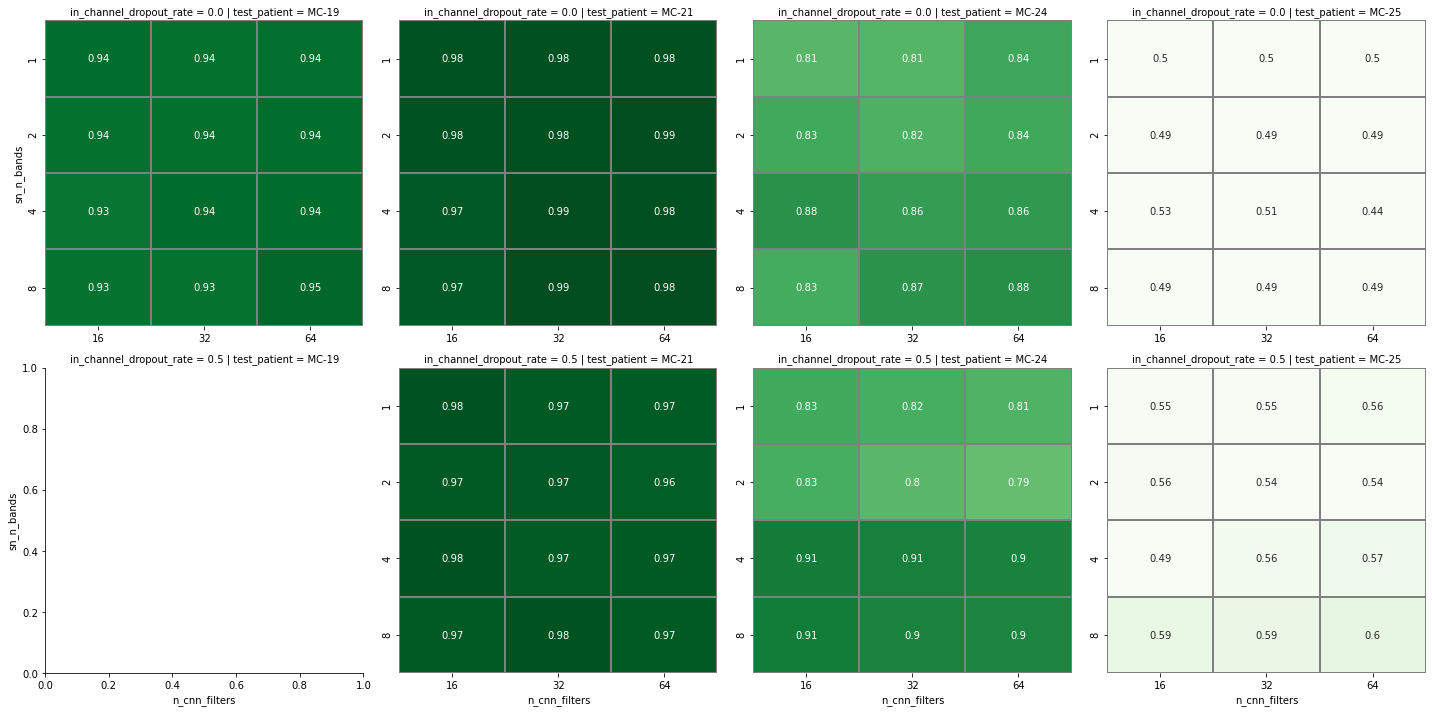

In [41]:
g = sns.FacetGrid(res_perf_df, col="test_patient", 
                  row='in_channel_dropout_rate',
                  # Sharing axis doesn't seem to work so well with sparse results - axes names and ticks get weird
                  sharex=False, sharey=False, height=5)
g.map_dataframe(hplot,'n_cnn_filters', 'sn_n_bands', 'f1',
                cmap='Greens', vmax=1., vmin=0.55, 
                cbar=False, linewidths=1, linecolor='grey')